## Requirement Installation

## Import Libraries

In [1]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

2026-01-16 00:27:11.990414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 00:27:12.031092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 00:27:13.156925: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/vqa-rad")

In [5]:

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

## Sample Visualization

Question: are the lungs normal appearing?
Answer: no


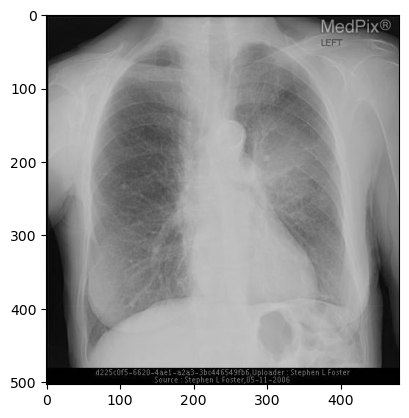

In [9]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [10]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

In [11]:
train_data = dataset['train']
val_data = dataset['test']

## Build Data-loader

In [25]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 224
        self.image_width = 224

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [7]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=train_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [13]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2024,  4655,  1997,  1996,  4167,  1999, 14971, 10985,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-1.6609, -1.6463, -1.6317,  ..., -1.6463, -1.5879, -1.5733],
         [-1.6463, -1.6317, -1.6171,  ..., -1.6171, -1.5879, -1.5733],
         [-1.6317, -1.6171, -1.6025,  ..., -1.5879, -1.5879, -1.5733],
         ...,
         [-1.7777, -1.7777, -1.7777,  ..., -1.7631, -1.7777, -1.7777],
         [-1.7777, -1.7777, -1.7777,  ..., -1.7631, -1.7777, -1.7777],
         [-1.7777, -1.7777, -1.7777,  ..., -1.7485, -1.7777, -1.7777]],

        [[-1.6170, -1.6020, -1.5870,  ..., -1.6020, -1.5420, -1.5270],
         [-1.6020, -1.5870, -1.5720,  ..., -1.5720, -1.5420, -1.527

In [14]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 224, 224])
labels torch.Size([64, 32])


## Build Model

In [ ]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)

# baseline

In [ ]:
def evaluate_accuracy(model, dataloader, processor, device):
    """
    计算模型在给定数据上的准确率
    """
    model.eval()  
    correct = 0
    total = 0
    
    print("正在进行评估 (Evaluation)... 请稍候")
    
    # 不计算梯度，节省显存并加速
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # 把数据移动到 GPU/CPU
            batch = {k:v.to(device) for k,v in batch.items()}
            
            # 让模型生成答案 (Inference)
            outputs = model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=batch['input_ids']
            )
            
            # 解码：把模型生成的数字变回文字
            predicted_answers = processor.batch_decode(outputs, skip_special_tokens=True)
            
            # 解码：把正确答案的数字变回文字
            actual_answers = processor.batch_decode(batch['labels'], skip_special_tokens=True)
            
            # 比对答案
            for pred, actual in zip(predicted_answers, actual_answers):
                # 转小写并去空格，防止 "Yes" 和 "yes " 被判定为不同
                if pred.lower().strip() == actual.lower().strip():
                    correct += 1
            
            total += len(predicted_answers)
    
    accuracy = correct / total
    print(f"评估结束! 样本总数: {total}, 正确数量: {correct}")
    print(f"准确率 (Accuracy): {accuracy:.2%}")
    
    return accuracy

In [ ]:
print("=== 方法 1: Baseline (Zero-shot Transfer) ===")

baseline_accuracy = evaluate_accuracy(model, val_dataloader, text_processor, device)

print("-" * 30)
print(f"Baseline 方法的准确率是: {baseline_accuracy:.2%}")
print("-" * 30)

=== 方法 1: Baseline (Zero-shot Transfer) ===
正在进行评估 (Evaluation)... 请稍候


  0%|          | 0/29 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


评估结束! 样本总数: 1793, 正确数量: 452
准确率 (Accuracy): 25.21%
------------------------------
Baseline 方法的准确率是: 25.21%
------------------------------


In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] are the lungs normal appearing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] no [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


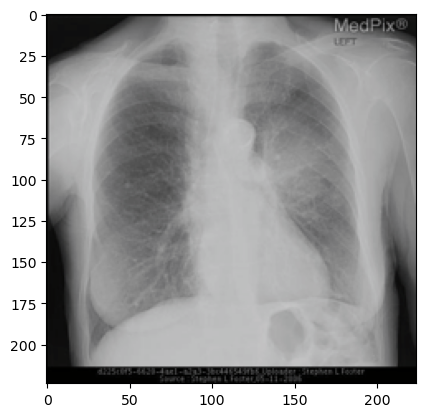

In [20]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

## Model Training

In [21]:
model.train()
for epoch in range(20):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 234.64239406585693
Epoch: 1


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 131.82390999794006
Epoch: 2


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 41.54582026600838
Epoch: 3


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 11.481811352074146
Epoch: 4


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 7.215030569583178
Epoch: 5


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 5.495082642883062
Epoch: 6


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 4.528494710102677
Epoch: 7


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.966000948101282
Epoch: 8


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.557732220739126
Epoch: 9


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.0483382251113653
Epoch: 10


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.5297908689826727
Epoch: 11


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.205786178819835
Epoch: 12


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.0652469284832478
Epoch: 13


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.8735431237146258
Epoch: 14


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.678039033897221
Epoch: 15


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.5405598599463701
Epoch: 16


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.4235821273177862
Epoch: 17


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.3619909188710153
Epoch: 18


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.2739839684218168
Epoch: 19


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.1752747604623437


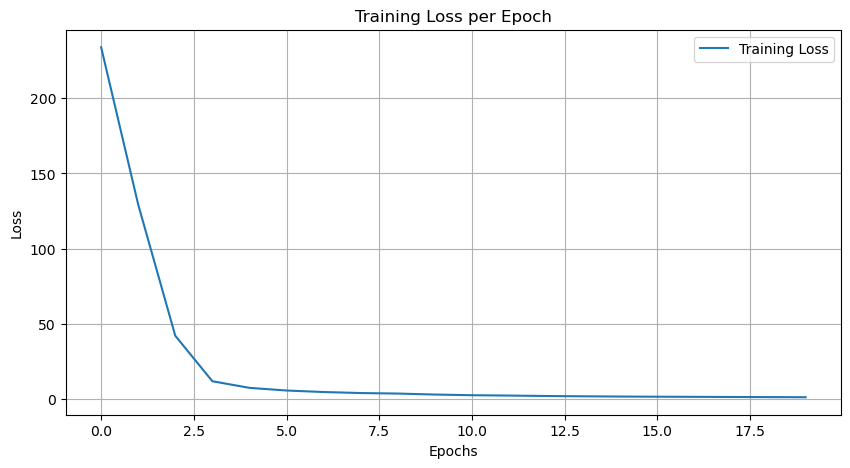

In [22]:
import matplotlib.pyplot as plt

# 从你的日志中提取出的完整 90 个 Loss 值
losses = [
    234.0037, 129.3013, 42.0292, 11.7718, 7.3717, 5.6038, 4.6009, 3.9251, 3.5779, 2.9285,
    2.4681, 2.2427, 1.9575, 1.7519, 1.5933, 1.4839, 1.4004, 1.3011, 1.2222, 1.1425,
]

# 画图代码
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
print("=== 方法 2: Proposed Method (Fine-tuning) ===")
# 再次使用同样的验证集进行测试
finetuned_accuracy = evaluate_accuracy(model, val_dataloader, text_processor, device)

print("-" * 30)
print(f"Proposed 方法 (微调后) 的准确率是: {finetuned_accuracy:.2%}")
print("-" * 30)

# 打印最终对比
print(f"结论: 经过微调，准确率提升了 {finetuned_accuracy - baseline_accuracy:.2%}")

=== 方法 2: Proposed Method (Fine-tuning) ===
正在进行评估 (Evaluation)... 请稍候


  0%|          | 0/29 [00:00<?, ?it/s]

评估结束! 样本总数: 1793, 正确数量: 765
准确率 (Accuracy): 42.67%
------------------------------
Proposed 方法 (微调后) 的准确率是: 42.67%
------------------------------
结论: 经过微调，准确率提升了 17.46%


## Inference

Closed-ended Accuracy: 0.7959183673469388
Open-ended BLEU: 0.1250870267730353


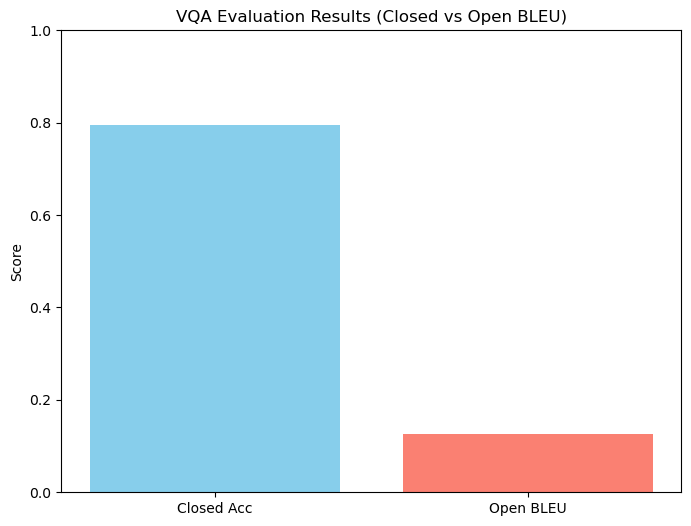

In [ ]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 统计 BLEU 分数
bleu_scores = []
closed_correct = 0
closed_total = 0

for x in range(100):
    sample = val_vqa_dataset[x]
    question = text_processor.decode(sample['input_ids'], skip_special_tokens=True)
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    outputs = model.generate(pixel_values=sample['pixel_values'],
                             input_ids=sample['input_ids'])
    # print(outputs)
    pred = text_processor.decode(outputs[0], skip_special_tokens=True)
    label = text_processor.decode(sample['labels'][0], skip_special_tokens=True)
    # print(label)
    # Closed-ended: Yes/No
    if label.lower() in ['yes','no']:
        closed_total += 1
        if pred.lower() == label.lower():
            closed_correct += 1
    else:
        # Open-ended: 用 BLEU 评估
        reference = [label.split()]   # 参考答案分词
        candidate = pred.split()      # 预测答案分词
        smoothie = SmoothingFunction().method1
        score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        bleu_scores.append(score)

# 计算指标
closed_acc = closed_correct / closed_total if closed_total > 0 else 0
open_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

print("Closed-ended Accuracy:", closed_acc)
print("Open-ended BLEU:", open_bleu)

# 可视化结果
metrics = ["Closed Acc", "Open BLEU"]
values = [closed_acc, open_bleu]

plt.figure(figsize=(8,6))
plt.bar(metrics, values, color=["skyblue","salmon"])
plt.ylabel("Score")
plt.title("VQA Evaluation Results (Closed vs Open BLEU)")
plt.ylim(0,1)
plt.show()

 

In [30]:
import pandas as pd

# 存储前10条 open-ended 和 closed-ended
open_samples = []
closed_samples = []

for x in range(100):
    sample = val_vqa_dataset[x]
    question = text_processor.decode(sample['input_ids'], skip_special_tokens=True)
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    outputs = model.generate(pixel_values=sample['pixel_values'],
                             input_ids=sample['input_ids'])
    pred = text_processor.decode(outputs[0], skip_special_tokens=True)
    label = text_processor.decode(sample['labels'][0], skip_special_tokens=True)

    # 区分 closed vs open
    if label.lower() in ['yes','no']:
        if len(closed_samples) < 10:
            closed_samples.append({"Question": question,
                                   "Predicted": pred,
                                   "Actual": label})
    else:
        if len(open_samples) < 10:
            open_samples.append({"Question": question,
                                 "Predicted": pred,
                                 "Actual": label})

    # 如果都收集满10条就停止
    if len(open_samples) >= 10 and len(closed_samples) >= 10:
        break

# 转换为 DataFrame
df_open = pd.DataFrame(open_samples)
df_closed = pd.DataFrame(closed_samples)
df_open.to_csv("open_ended.csv", index=False, encoding="utf-8")
df_closed.to_csv("closed_ended.csv", index=False, encoding="utf-8")

print("=== 前10条 Open-ended ===")
print(df_open.to_string(index=False))

print("\n=== 前10条 Closed-ended ===")
print(df_closed.to_string(index=False))


=== 前10条 Open-ended ===
                                     Question                                           Predicted                                              Actual
which organ system is abnormal in this image?                                                  gi                                      cardiovascular
                    how was this image taken?                                       with contrast                                                 mri
         what is the condition of the patient blind - ending loop of bowel arising from the cecum                                 blind loop syndrome
                    what abnormality is seen?                                           emphysema blind - ending loop of bowel arising from the cecum
            what is the location of the mass?                                       pineal region                                       pineal region
                           where is the mass?                               

Question:  are regions of the brain infarcted?
Predicted Answer:  yes
Actual Answer:  yes


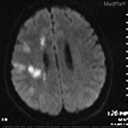

###################################################################
Question:  are the lungs normal appearing?
Predicted Answer:  no
Actual Answer:  no


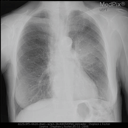

###################################################################
Question:  which organ system is abnormal in this image?
Predicted Answer:  gi
Actual Answer:  cardiovascular


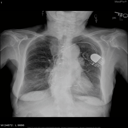

###################################################################
Question:  is the lesion causing significant brainstem herniation?
Predicted Answer:  no
Actual Answer:  no


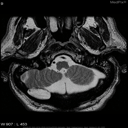

###################################################################
Question:  how was this image taken?
Predicted Answer:  with contrast
Actual Answer:  mri


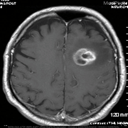

###################################################################
Question:  what is the condition of the patient
Predicted Answer:  blind - ending loop of bowel arising from the cecum
Actual Answer:  blind loop syndrome


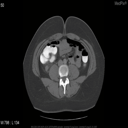

###################################################################
Question:  what abnormality is seen?
Predicted Answer:  emphysema
Actual Answer:  blind - ending loop of bowel arising from the cecum


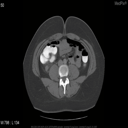

###################################################################
Question:  what is the location of the mass?
Predicted Answer:  pineal region
Actual Answer:  pineal region


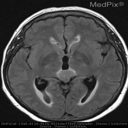

###################################################################
Question:  where is the mass?
Predicted Answer:  pineal region
Actual Answer:  pineal region


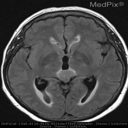

###################################################################
Question:  is this image in the transverse plane?
Predicted Answer:  yes
Actual Answer:  yes


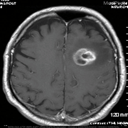

###################################################################
Question:  are there any pulmonary findings?
Predicted Answer:  no
Actual Answer:  no


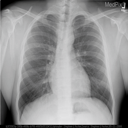

###################################################################
Question:  are the lungs affected?
Predicted Answer:  a bit
Actual Answer:  no


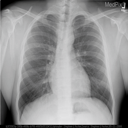

###################################################################
Question:  in which lobe are the lesions?
Predicted Answer:  aorta
Actual Answer:  bilateral frontal lobes


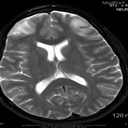

###################################################################
Question:  where are the lesions?
Predicted Answer:  pons
Actual Answer:  bilateral frontal lobes


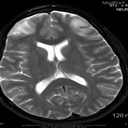

###################################################################
Question:  is there herniation of the brainstem secondary to the lesion
Predicted Answer:  no
Actual Answer:  no


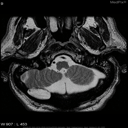

###################################################################
Question:  what type of image is this?
Predicted Answer:  mr - flair
Actual Answer:  mri - dwi


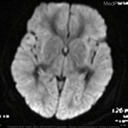

###################################################################
Question:  is the gyral enhancement?
Predicted Answer:  yes
Actual Answer:  yes


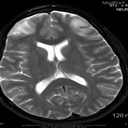

###################################################################
Question:  what is the location of the abnormality?
Predicted Answer:  right colon
Actual Answer:  right colon


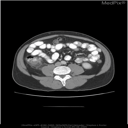

###################################################################
Question:  where is the abnormal finding?
Predicted Answer:  a bit
Actual Answer:  right colon


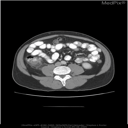

###################################################################
Question:  what plane is seen?
Predicted Answer:  pa
Actual Answer:  pa


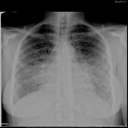

###################################################################
Question:  how would you describe the mass?
Predicted Answer:  more than half the thorax
Actual Answer:  isointense


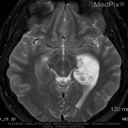

###################################################################
Question:  what are the characteristics of the mass?
Predicted Answer:  more than half the thorax
Actual Answer:  isointense


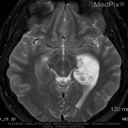

###################################################################
Question:  which plane is this image taken in?
Predicted Answer:  pa
Actual Answer:  pa


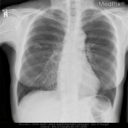

###################################################################
Question:  is the mass hyperintense or hypointense?
Predicted Answer:  hyperintense
Actual Answer:  hyperintense


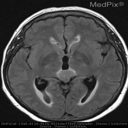

###################################################################
Question:  what is the radiological description of the mass?
Predicted Answer:  hyperintense
Actual Answer:  hyperintense


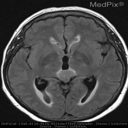

###################################################################
Question:  is it difficult to delineate the left costophrenic angle?
Predicted Answer:  yes
Actual Answer:  yes


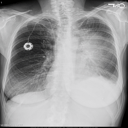

###################################################################
Question:  what allows for the bright areas seen in this image?
Predicted Answer:  mass
Actual Answer:  iv contrast


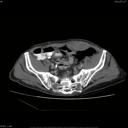

###################################################################
Question:  is this an mri?
Predicted Answer:  a bit
Actual Answer:  no


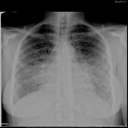

###################################################################
Question:  is the mass heterogenous?
Predicted Answer:  yes
Actual Answer:  yes


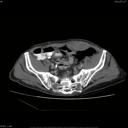

###################################################################
Question:  is the mass heterogenous in consistency?
Predicted Answer:  yes
Actual Answer:  yes


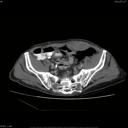

###################################################################
Question:  are there abnormalities with in the contrast between white and grey matter?
Predicted Answer:  yes
Actual Answer:  yes


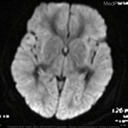

###################################################################
Question:  is the gray - white matter junction altered?
Predicted Answer:  yes
Actual Answer:  yes


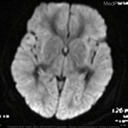

###################################################################
Question:  is there evidence of inflammation?
Predicted Answer:  yes
Actual Answer:  yes


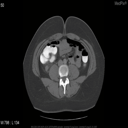

###################################################################
Question:  is any structure inflamed?
Predicted Answer:  yes
Actual Answer:  yes


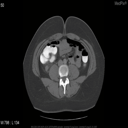

###################################################################
Question:  is the image in the axial plane?
Predicted Answer:  yes
Actual Answer:  yes


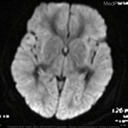

###################################################################
Question:  how can the distribution in this image be described?
Predicted Answer:  micronodular
Actual Answer:  micronodular


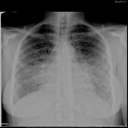

###################################################################
Question:  is there blunting of the left costophrenic angle?
Predicted Answer:  no
Actual Answer:  yes


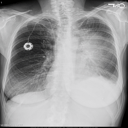

###################################################################
Question:  what type of distributions is seen on this image?
Predicted Answer:  micronodular
Actual Answer:  micronodular


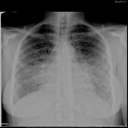

###################################################################
Question:  what is the location of the mass?
Predicted Answer:  right mca
Actual Answer:  left rectus abdominus


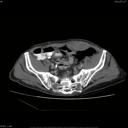

###################################################################
Question:  where is the mass?
Predicted Answer:  right sided pleural effusion
Actual Answer:  left rectus abdominus


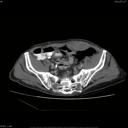

###################################################################
Question:  is this a t1 weighted image?
Predicted Answer:  no
Actual Answer:  no


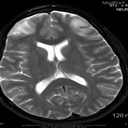

###################################################################
Question:  is the right renal vein visualized?
Predicted Answer:  pleural effusion
Actual Answer:  no


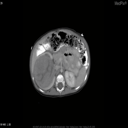

###################################################################
Question:  is it possible to identify the right renal vein?
Predicted Answer:  no
Actual Answer:  no


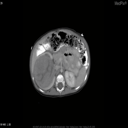

###################################################################
Question:  are the kidneys visible in this image?
Predicted Answer:  yes
Actual Answer:  yes


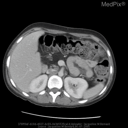

###################################################################
Question:  is air visible in the bowels?
Predicted Answer:  yes
Actual Answer:  yes


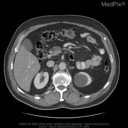

###################################################################
Question:  is there air in the bowel?
Predicted Answer:  yes
Actual Answer:  yes


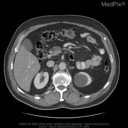

###################################################################
Question:  what do the two bright dots represent?
Predicted Answer:  nipple location
Actual Answer:  nipple location


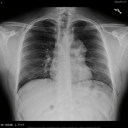

###################################################################
Question:  are structures associated with the midbrain located in this image?
Predicted Answer:  yes
Actual Answer:  yes


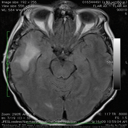

###################################################################
Question:  what are the two hyperlucent inferior dots?
Predicted Answer:  more than half the diameter of the aorta
Actual Answer:  nipple location


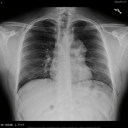

###################################################################
Question:  what are the locations of the hyperintensities?
Predicted Answer:  pleural effusion
Actual Answer:  bilateral frontal lobes and body of corpus callosum


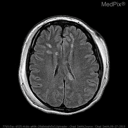

###################################################################
Question:  where are the hyperintensities located?
Predicted Answer:  right cerebellum
Actual Answer:  bilateral frontal lobes and body of corpus callosum


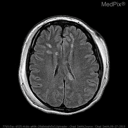

###################################################################
Question:  are the kidneys visualized?
Predicted Answer:  yes
Actual Answer:  yes


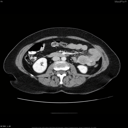

###################################################################
Question:  can you see the kidneys
Predicted Answer:  yes
Actual Answer:  yes


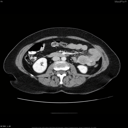

###################################################################
Question:  is this a pa or ap film?
Predicted Answer:  pa
Actual Answer:  pa


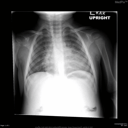

###################################################################
Question:  what laterality is this film?
Predicted Answer:  multilobulated
Actual Answer:  pa


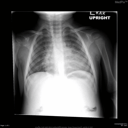

###################################################################
Question:  what artery is the embolus from?
Predicted Answer:  basilar artery
Actual Answer:  distal basilar artery


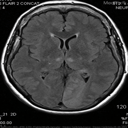

###################################################################
Question:  where is the embolus located?
Predicted Answer:  right parietal lobe
Actual Answer:  distal basilar artery


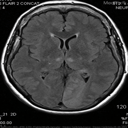

###################################################################
Question:  the mass is located in what region?
Predicted Answer:  multi -ing
Actual Answer:  suprasellar


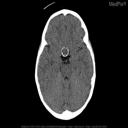

###################################################################
Question:  is the midbrain identified in this section?
Predicted Answer:  yes
Actual Answer:  yes


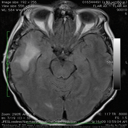

###################################################################
Question:  where is the mass located?
Predicted Answer:  right sided pleural effusion
Actual Answer:  suprasellar


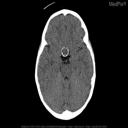

###################################################################
Question:  the imaging modality is...?
Predicted Answer:  x - ray
Actual Answer:  mri / flair


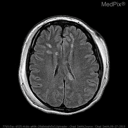

###################################################################
Question:  what is the image modality?
Predicted Answer:  more than half the diameter of the thoracic cavity.
Actual Answer:  mri / flair


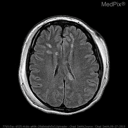

###################################################################
Question:  is there fluid in the lungs?
Predicted Answer:  yes
Actual Answer:  no


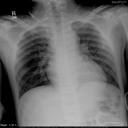

###################################################################
Question:  is a pleural effusion present?
Predicted Answer:  yes
Actual Answer:  no


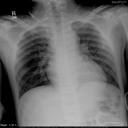

###################################################################
Question:  is this an axial cut?
Predicted Answer:  yes
Actual Answer:  yes


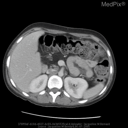

###################################################################
Question:  is the trachea deviated?
Predicted Answer:  no
Actual Answer:  yes


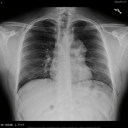

###################################################################
Question:  is tracheal deviation present?
Predicted Answer:  yes
Actual Answer:  yes


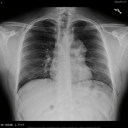

###################################################################
Question:  what image modality is this?
Predicted Answer:  ct
Actual Answer:  ct


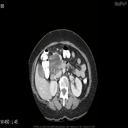

###################################################################
Question:  what imaging modality was used
Predicted Answer:  ct
Actual Answer:  ct


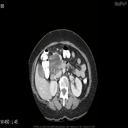

###################################################################
Question:  are there more than 5 enlarged ( > 1 cm ) lymph nodes around the stomach
Predicted Answer:  yes
Actual Answer:  yes


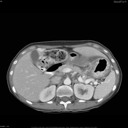

###################################################################
Question:  are patchy infiltrates depicted?
Predicted Answer:  yes
Actual Answer:  yes


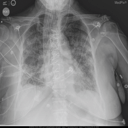

###################################################################
Question:  are there patchy infiltrates present?
Predicted Answer:  yes
Actual Answer:  yes


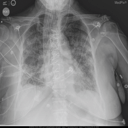

###################################################################
Question:  are the margins of the cardiac silhouette normal?
Predicted Answer:  yes
Actual Answer:  no


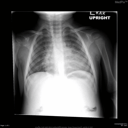

###################################################################
Question:  is the heart border normal?
Predicted Answer:  no
Actual Answer:  no


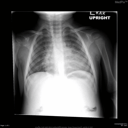

###################################################################
Question:  is this an axial plane
Predicted Answer:  yes
Actual Answer:  yes


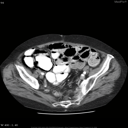

###################################################################
Question:  is there intrahepatic ductal dilatation?
Predicted Answer:  yes
Actual Answer:  yes


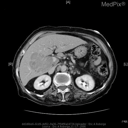

###################################################################
Question:  is intrahepatic ductal dilatation present?
Predicted Answer:  yes
Actual Answer:  yes


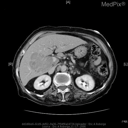

###################################################################
Question:  what imaging modality was used?
Predicted Answer:  x - ray
Actual Answer:  x - ray


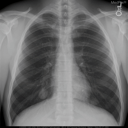

###################################################################
Question:  what type of image is this?
Predicted Answer:  x - ray
Actual Answer:  x - ray


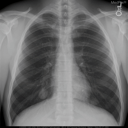

###################################################################
Question:  are air fluid levels depicted in this image?
Predicted Answer:  yes
Actual Answer:  yes


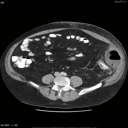

###################################################################
Question:  are there > 5 lymph nodes located near the stomach?
Predicted Answer:  yes
Actual Answer:  yes


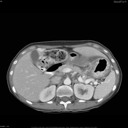

###################################################################
Question:  is there an air fluid level present?
Predicted Answer:  yes
Actual Answer:  yes


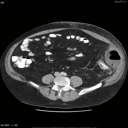

###################################################################
Question:  where is the pathology located?
Predicted Answer:  a bit
Actual Answer:  anterior cerebrum


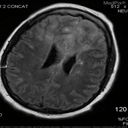

###################################################################
Question:  which region of the brain is impacted?
Predicted Answer:  anterior surface
Actual Answer:  anterior surface


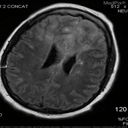

###################################################################
Question:  is there air in the bowel?
Predicted Answer:  yes
Actual Answer:  yes


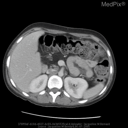

###################################################################
Question:  is air present in the bowel?
Predicted Answer:  a bit
Actual Answer:  yes


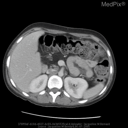

###################################################################
Question:  what is behind the liver?
Predicted Answer:  ascites
Actual Answer:  ascites


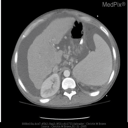

###################################################################
Question:  what finding is associated with liver?
Predicted Answer:  ascites
Actual Answer:  ascites


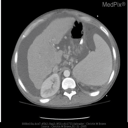

###################################################################
Question:  what type of image is this?
Predicted Answer:  mri - flair
Actual Answer:  mri - flair


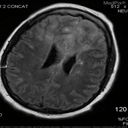

###################################################################
Question:  what imaging modality was used
Predicted Answer:  mri - t2 weighted
Actual Answer:  mri - flair


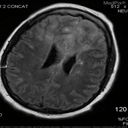

###################################################################
Question:  what imaging plane is depicted here?
Predicted Answer:  axial
Actual Answer:  axial


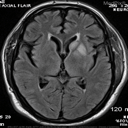

###################################################################
Question:  does the gallbladder appear distended?
Predicted Answer:  yes
Actual Answer:  yes


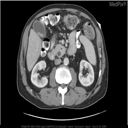

###################################################################
Question:  what is the plane?
Predicted Answer:  the antrum
Actual Answer:  axial


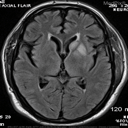

###################################################################
Question:  is cardiomegaly shown?
Predicted Answer:  yes
Actual Answer:  yes


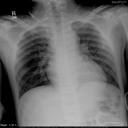

###################################################################
Question:  is the heart enlarged?
Predicted Answer:  a bit
Actual Answer:  yes


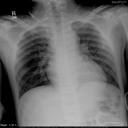

###################################################################
Question:  what is the location of the mass?
Predicted Answer:  right sided pleural effusion
Actual Answer:  right kidney


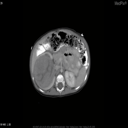

###################################################################
Question:  where is the mass located?
Predicted Answer:  right sided pleural effusion
Actual Answer:  right kidney


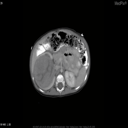

###################################################################
Question:  how was this image taken?
Predicted Answer:  with contrast
Actual Answer:  with contrast


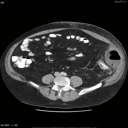

###################################################################
Question:  what do the hyperintensities likely represent?
Predicted Answer:  pleural effusion
Actual Answer:  hemorrhage


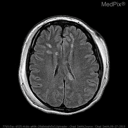

###################################################################
Question:  what are the hyperintensities signaling?
Predicted Answer:  emphysema
Actual Answer:  hemorrhage


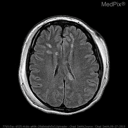

###################################################################


In [31]:
# add batch dimension + move to GPU|
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

Question:  is a noncontrast ct the first imaging test for a suspected brain bleed?
Predicted Answer:  yes
Actual Answer:  yes


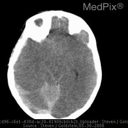

###################################################################
Question:  what plane is this image in?
Predicted Answer:  axial
Actual Answer:  axial


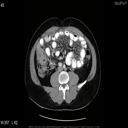

###################################################################
Question:  is there a fracture?
Predicted Answer:  no
Actual Answer:  no


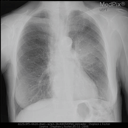

###################################################################
Question:  how would you describe the lesion?
Predicted Answer:  more than half the thorax
Actual Answer:  ring - enhancing lesion


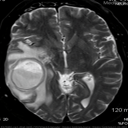

###################################################################
Question:  is the heart size abnormal?
Predicted Answer:  more than half the thorax
Actual Answer:  yes


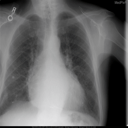

###################################################################
Question:  in what plane was this image taken?
Predicted Answer:  axial
Actual Answer:  axial


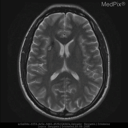

###################################################################
Question:  what plane was this image taken in?
Predicted Answer:  axial
Actual Answer:  axial


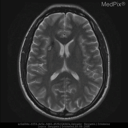

###################################################################
Question:  the image has an abnormality located where?
Predicted Answer:  a bit
Actual Answer:  retrocardiac


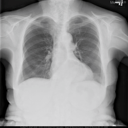

###################################################################
Question:  where is the abnormality located in this image?
Predicted Answer:  right sided pleural effusion
Actual Answer:  retrocardiac


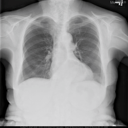

###################################################################
Question:  are there any abnormalities seen in the spleen?
Predicted Answer:  no
Actual Answer:  no


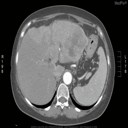

###################################################################
Question:  what is the pathology seen in the spleen?
Predicted Answer:  emphysema
Actual Answer:  nothing


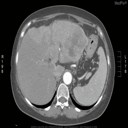

###################################################################
Question:  what structure in the left basal ganglia is spared?
Predicted Answer:  sigmoid flexture of the colon
Actual Answer:  left thalamus


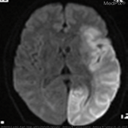

###################################################################
Question:  what is spared in the left basal ganglia?
Predicted Answer:  the left sinus
Actual Answer:  left thalamus


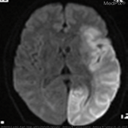

###################################################################
Question:  pathology seen in this image?
Predicted Answer:  more than half the diameter of the thoracic cavity.
Actual Answer:  small subdural hematoma with cerebral edema


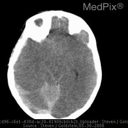

###################################################################
Question:  what are key characteristics of the lesion?
Predicted Answer:  more than half the thorax
Actual Answer:  ring - enhancing lesion


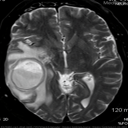

###################################################################
Question:  what is the condition seen in this image?
Predicted Answer:  more than half the thorax
Actual Answer:  small subdural hematoma with cerebral edema


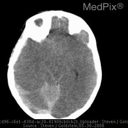

###################################################################
Question:  are there pleural effusions present?
Predicted Answer:  no
Actual Answer:  no


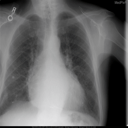

###################################################################
Question:  is there presence of pleural effusions in this patient?
Predicted Answer:  no
Actual Answer:  no


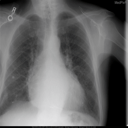

###################################################################
Question:  free air is seen where in this image?
Predicted Answer:  peritoneum
Actual Answer:  adjacent to the appendix


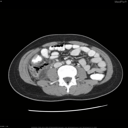

###################################################################
Question:  where is the free - air seen in this image?
Predicted Answer:  peritoneum
Actual Answer:  adjacent to the appendix


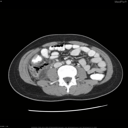

###################################################################
Question:  is this an mri image?
Predicted Answer:  more than half the thorax
Actual Answer:  no


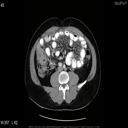

###################################################################
Question:  the infarction is likely caused by what vessel?
Predicted Answer:  necrosis
Actual Answer:  left mca


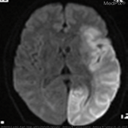

###################################################################
Question:  what vessel is likely the cause of this infarction?
Predicted Answer:  more than one
Actual Answer:  left mca


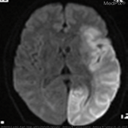

###################################################################
Question:  is this film taken ap?
Predicted Answer:  the pain is not well viewed by x rays
Actual Answer:  no


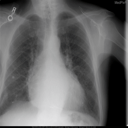

###################################################################
Question:  are there any abnormalities in the kidneys?
Predicted Answer:  no
Actual Answer:  no


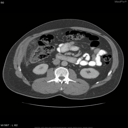

###################################################################
Question:  are there abnormal findings on this image?
Predicted Answer:  yes
Actual Answer:  yes


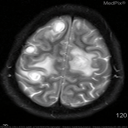

###################################################################
Question:  notice any abnormality in the kidneys?
Predicted Answer:  no
Actual Answer:  no


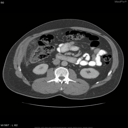

###################################################################
Question:  what would you call the lesions seen?
Predicted Answer:  pons
Actual Answer:  ms plaques


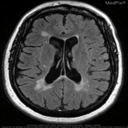

###################################################################
Question:  what is the name of the lesions seen in this image?
Predicted Answer:  pleural effusion
Actual Answer:  ms plaques


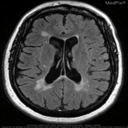

###################################################################
Question:  is this a plain film xray?
Predicted Answer:  yes
Actual Answer:  yes


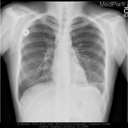

###################################################################
Question:  are the costophrenic angles blunted?
Predicted Answer:  no
Actual Answer:  no


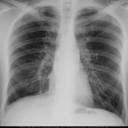

###################################################################
Question:  is there any blunting of the costophrenic angle ( s )?
Predicted Answer:  no
Actual Answer:  no


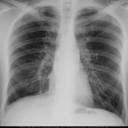

###################################################################
Question:  there is mesenteric lymphadenopathy present, what additional region is seeded?
Predicted Answer:  peritoneum
Actual Answer:  peritoneum


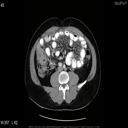

###################################################################
Question:  we see mesenteric lymphadenopathy in the above image, where else is there cancer?
Predicted Answer:  peritoneum
Actual Answer:  peritoneum


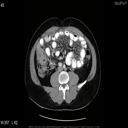

###################################################################
Question:  what is the vascular distribution of these infarcts?
Predicted Answer:  all three vascular distributions
Actual Answer:  all three vascular distributions


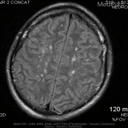

###################################################################
Question:  where are the infarcts located?
Predicted Answer:  anterior cerebrum
Actual Answer:  diffuse


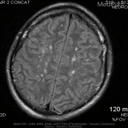

###################################################################
Question:  is this brain scan normal?
Predicted Answer:  a bit
Actual Answer:  no


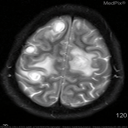

###################################################################
Question:  the pathology seen in this image is typical of what disease?
Predicted Answer:  multiple sclerosis
Actual Answer:  multiple sclerosis


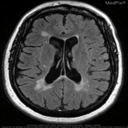

###################################################################
Question:  what disease does the pathology suggest?
Predicted Answer:  multiple sclerosis
Actual Answer:  multiple sclerosis


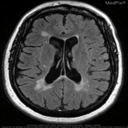

###################################################################
Question:  in what parts of the brain are the lesions located?
Predicted Answer:  oculomotor nerve ( cn iii ) and trigeminal nerves ( cn v )
Actual Answer:  cerebrum and lateral ventricles


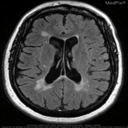

###################################################################
Question:  where do you see the lesions?
Predicted Answer:  cerebrum and lateral ventricles
Actual Answer:  cerebrum and lateral ventricles


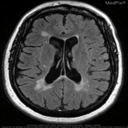

###################################################################
Question:  any tracheal deviation present?
Predicted Answer:  1
Actual Answer:  no


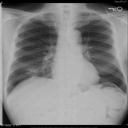

###################################################################
Question:  is there any presence of tracheal deviation?
Predicted Answer:  no
Actual Answer:  no


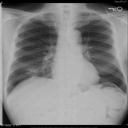

###################################################################
Question:  where is the abnormality located?
Predicted Answer:  right sided pleural effusion
Actual Answer:  right convexity


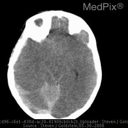

###################################################################
Question:  where is the pathology located?
Predicted Answer:  a bit
Actual Answer:  right convexity


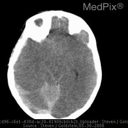

###################################################################


In [32]:
for x in range(555,600):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

Question:  what are the hyperintensities seen in the bilateral kidneys?
Predicted Answer:  emphysema
Actual Answer:  contrast


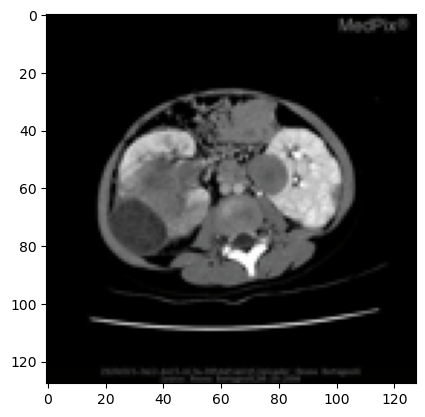

In [33]:
idx = 751
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  how do you know if contrast was used?
Predicted Answer:  enhancement of vessels
Actual Answer:  enhancement of vessels


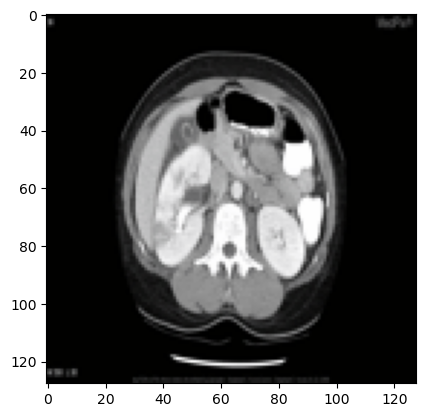

In [34]:
idx = 700
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  please identify the foreign body.
Predicted Answer:  a catheter
Actual Answer:  a catheter


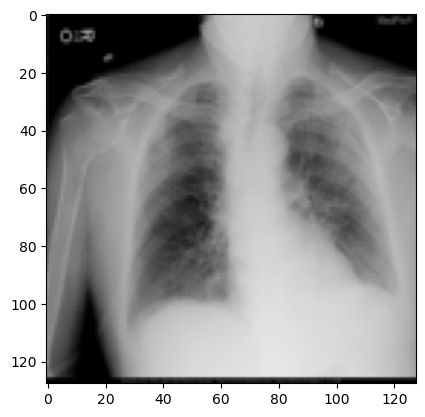

In [35]:
idx = 720
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  what is the pathology seen above?
Predicted Answer:  a bit
Actual Answer:  bilateral pleural effusion


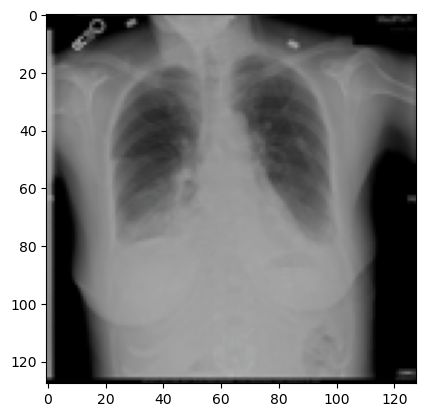

In [36]:
idx = 790
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  where is the lesion?
Predicted Answer:  right parietal lobe
Actual Answer:  right parietal lobe


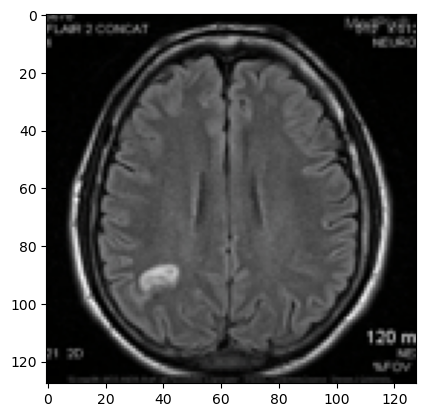

In [37]:
idx = 885
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  which cerebral cortex contains the lesion?
Predicted Answer:  diffuse
Actual Answer:  diffuse


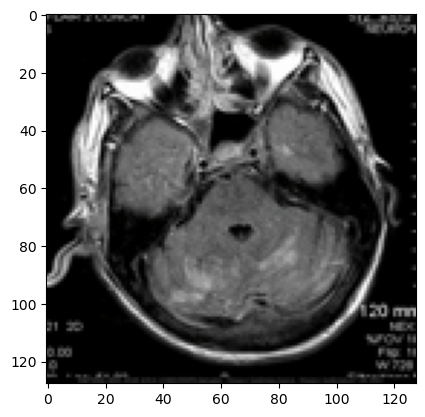

In [38]:
idx = 822
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  what are defining radiological features of the small bowel?
Predicted Answer:  more vessels
Actual Answer:  not sure


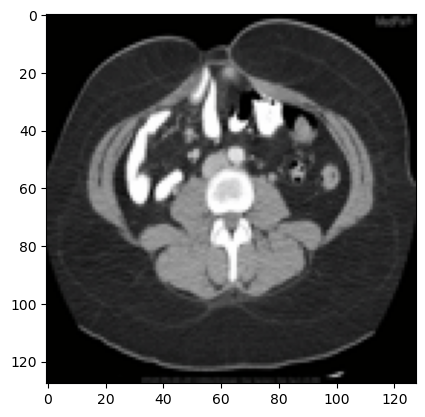

In [39]:
idx = 770
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  what tells you that the image is t2?
Predicted Answer:  more than half the diameter of the aorta
Actual Answer:  white versus grey matter brightness


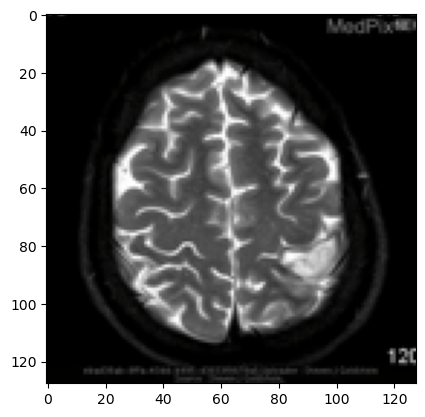

In [40]:
idx = 777
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

## Conclusion

A successfully trained and inferred medical Visual Question Answering model has the potential to revolutionize healthcare by enhancing diagnostic accuracy, improving efficiency, and expanding access to medical information. However, careful consideration of ethical, privacy, and regulatory issues is crucial to ensure its safe and responsible use in clinical practice.

In [41]:
# 保存模型权重
torch.save(model.state_dict(), 'my_model_epoch90_BLIP.pth')
print("模型已保存！")

# 如果你是用 transformers (CLIP/BERT等) 的 save_pretrained 方法：
# model.save_pretrained("./my_clip_model_75")
# processor.save_pretrained("./my_clip_model_75")

模型已保存！


In [26]:
import torch
from transformers import BlipForQuestionAnswering

# 1. 重新初始化一个“干净”的 BLIP 模型结构
# 必须和训练时使用的预训练模型名称一致
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# 2. 定义你保存的权重文件路径
checkpoint_path = 'my_model_epoch90_BLIP.pth'

# 3. 加载权重
# map_location=device 确保如果此时只有 CPU 也能加载 GPU 训练的权重
print(f"正在加载训练好的模型权重: {checkpoint_path} ...")
checkpoint = torch.load(checkpoint_path, map_location=device)

# 4. 将权重注入模型
# strict=False 可以容忍一些微小的键名不匹配，但通常你存取的是同一个模型，不需要设为 False
model.load_state_dict(checkpoint)
model.to(device)

print("成功！原本的模型权重已加载完毕。")

正在加载训练好的模型权重: my_model_epoch90_BLIP.pth ...
成功！原本的模型权重已加载完毕。


In [ ]:
import torch
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_comprehensive_fixed(model, dataset, processor, device):
    model.eval()
    
    stats = {
        "closed": {"correct": 0, "total": 0},
        "open": {"correct": 0, "total": 0, "bleu_sum": 0},
        "all": {"correct": 0, "total": 0}
    }
    
    smoother = SmoothingFunction().method1 
    
    print(f"🚀 开始修正后的评估 (样本数: {len(dataset)})...")
    
    with torch.no_grad():
        for i, item in enumerate(tqdm(dataset)):
            image = item['image']
            question = item['question']
            answer = str(item['answer'])
            
            # --- 核心修复：自动检测分类 ---
            ans_clean = answer.lower().strip()
            
            # 1. 优先尝试获取数据集自带的标签
            raw_type = str(item.get('answer_type', 'OPEN')).upper()
            
            # 2. 强制修正逻辑：如果答案是 yes/no，强制归为 CLOSED
            if ans_clean in ['yes', 'no']:
                final_type = 'CLOSED'
            # 3. 如果答案很短（比如 'left', 'right'），通常也是封闭问题
            elif len(ans_clean.split()) == 1 and raw_type != 'OPEN': 
                final_type = 'CLOSED'
            else:
                final_type = raw_type

            # --- 推理 ---
            inputs = processor(images=image, text=question, return_tensors="pt").to(device)
            output_ids = model.generate(**inputs, max_length=50)
            pred_answer = processor.decode(output_ids[0], skip_special_tokens=True)
            pred_clean = pred_answer.lower().strip()
            
            # --- 判分 ---
            # 只要预测包含答案(比如 "yes, it is" 包含 "yes") 就算对
            is_correct = (pred_clean == ans_clean) or (ans_clean in pred_clean)
            
            # 全局统计
            stats["all"]["total"] += 1
            if is_correct: stats["all"]["correct"] += 1
            
            # 分类统计
            if "CLOSED" in final_type:
                stats["closed"]["total"] += 1
                if is_correct: stats["closed"]["correct"] += 1
            else:
                stats["open"]["total"] += 1
                if is_correct: stats["open"]["correct"] += 1
                
                # 计算 BLEU
                ref_tokens = ans_clean.split()
                cand_tokens = pred_clean.split()
                if len(ref_tokens) > 0 and len(cand_tokens) > 0:
                    score = sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoother)
                    stats["open"]["bleu_sum"] += score

            # 打印几个样本来看看修正效果
            if i < 5: 
                print(f"Q: {question}")
                print(f"True: {answer} | Pred: {pred_answer} | Correct: {is_correct}\n")

    # --- 报告 ---
    print("\n" + "="*40)
    print("="*40)
    
    acc_all = stats["all"]["correct"] / stats["all"]["total"]
    print(f"Overall Accuracy: {acc_all:.2%} ({stats['all']['correct']}/{stats['all']['total']})")
    
    if stats["closed"]["total"] > 0:
        acc_closed = stats["closed"]["correct"] / stats["closed"]["total"]
        print(f"Closed-Ended Acc: {acc_closed:.2%} ({stats['closed']['correct']}/{stats['closed']['total']})")
    
    if stats["open"]["total"] > 0:
        acc_open = stats["open"]["correct"] / stats["open"]["total"]
        avg_bleu = stats["open"]["bleu_sum"] / stats["open"]["total"]
        print(f"Open-Ended Acc  : {acc_open:.2%} ({stats['open']['correct']}/{stats['open']['total']})")
        print(f"Open-Ended BLEU : {avg_bleu:.4f}")
        
    return stats

# 运行修正后的评估
stats = evaluate_comprehensive_fixed(model, dataset['test'], text_processor, device)

🚀 开始修正后的评估 (样本数: 451)...


  0%|          | 0/451 [00:00<?, ?it/s]

Q: is there evidence of an aortic aneurysm?
True: yes | Pred: no | Correct: False

Q: is there airspace consolidation on the left side?
True: yes | Pred: no | Correct: False

Q: is there any intraparenchymal abnormalities in the lung fields?
True: no | Pred: no | Correct: True

Q: which side of the heart border is obscured?
True: right | Pred: right | Correct: True

Q: where are the kidney?
True: not seen here | Pred: right side | Correct: False


       📊 FIXED REPORT       
Overall Accuracy: 45.45% (205/451)
Closed-Ended Acc: 66.53% (167/251)
Open-Ended Acc  : 19.00% (38/200)
Open-Ended BLEU : 0.0532


In [33]:
stats_BLIP = stats
stats_BLIP

{'closed': {'correct': 167, 'total': 251},
 'open': {'correct': 38, 'total': 200, 'bleu_sum': 10.632898236548701},
 'all': {'correct': 205, 'total': 451}}

# CLIP

Loading CLIP model...
Starting training...
Epoch: 1/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 Average Loss: 1.4566
Epoch: 2/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 Average Loss: 1.1322
Epoch: 3/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 Average Loss: 0.8322
Epoch: 4/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 Average Loss: 0.6133
Epoch: 5/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 Average Loss: 0.4388
Epoch: 6/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 Average Loss: 0.3371
Epoch: 7/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 Average Loss: 0.2608
Epoch: 8/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 Average Loss: 0.2200
Epoch: 9/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 Average Loss: 0.2142
Epoch: 10/10


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 Average Loss: 0.1678


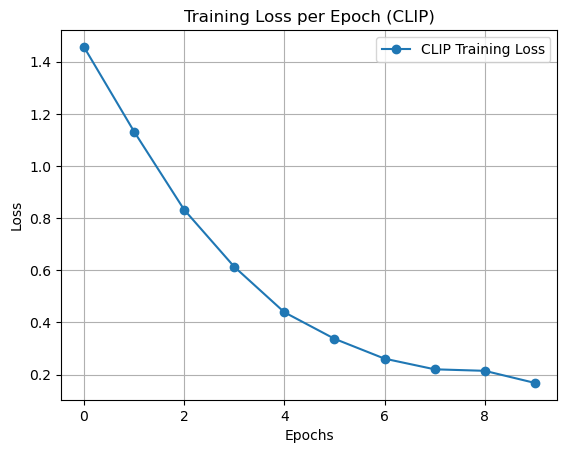

In [36]:
# 1. 导入 CLIP 相关的库
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# 2. 加载 CLIP 模型和处理器
# "openai/clip-vit-base-patch32" 是最通用的预训练版本
print("Loading CLIP model...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# 3. 定义适配 CLIP 的数据集类
# 这一步非常关键：它负责把你的原始数据转换成 CLIP 能“看懂”的格式
class CLIPVQADataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, processor):
        self.dataset = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    # def __getitem__(self, idx):
    #     item = self.dataset[idx]
    #     image = item['image']
        
    #     # 这里我们将图片和问题配对。
    #     # 如果你想把答案也加进去，可以改成: text = item['question'] + " " + str(item['answer'])
    #     text = item['question'] 
        
    #     # 使用 processor 统一处理图片和文本
    #     # padding="max_length" 保证每个 batch 长度一致
    #     # truncation=True 截断过长的文本
    #     inputs = self.processor(
    #         text=[text], 
    #         images=image, 
    #         return_tensors="pt", 
    #         padding="max_length", 
    #         truncation=True,
    #         size={"height": 224, "width": 224}
    #     )
        
    #     # processor 返回的 tensor 多了一维 batch (1, ...)，我们需要去掉它
    #     return {k: v.squeeze(0) for k, v in inputs.items()}
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        
        # --- 修改开始 ---
        # 把答案拼接在问题后面，让 CLIP 学会匹配完整的问答对
        q = item['question']
        a = str(item['answer'])
        text = f"Question: {q} Answer: {a}" 
        # --- 修改结束 ---
        
        inputs = self.processor(
            text=[text], 
            images=image, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True
        )
        return {k: v.squeeze(0) for k, v in inputs.items()}
# 4. 准备 DataLoader
# 假设你的原始数据集变量叫 'dataset'，且有 'train' 分支
train_ds_clip = CLIPVQADataset(dataset['train'], processor)
# batch_size 建议设小一点（比如 4 或 8），因为 CLIP 比较占显存
train_dataloader_clip = DataLoader(train_ds_clip, batch_size=8, shuffle=True)

# 5. 定义优化器
# CLIP 是预训练模型，学习率(lr)要设置得很小，不然容易破坏原有参数
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)

# 6. 训练循环 (包含画图数据收集)
print("Starting training...")
model.train()
epoch_losses = [] # 用于存储每个 epoch 的 loss

epochs = 10

for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    batch_losses = []
    
    for batch in tqdm(train_dataloader_clip):
        # 把数据移动到 GPU (device)
        batch = {k: v.to(device) for k, v in batch.items()}

        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播 (CLIP 内部会自动计算 Image-Text Contrastive Loss)
        # 原来的代码（会导致 loss 为 None）
        # outputs = model(**batch) 
        
        # 修改后的代码：强制模型返回 Loss
        outputs = model(**batch, return_loss=True)
        
        loss = outputs.loss
        
        # 记录 loss
        batch_losses.append(loss.item())
        
        # 反向传播 + 优化
        loss.backward()
        optimizer.step()
    
    # 计算本轮平均 Loss
    epoch_avg_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(epoch_avg_loss)
    print(f"Epoch {epoch + 1} Average Loss: {epoch_avg_loss:.4f}")

# 7. 画出 Loss 曲线 plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='CLIP Training Loss', marker='o')
plt.title('Training Loss per Epoch (CLIP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import torch
from tqdm.notebook import tqdm

def evaluate_clip_vqa(model, dataset, processor, device):
    """
    使用 CLIP 对 Yes/No 问题进行分类评估
    """
    model.eval()
    correct = 0
    total = 0
    
    print("🚀 开始 CLIP 模型评估 (仅针对 Yes/No 问题)...")
    
    with torch.no_grad():
        for item in tqdm(dataset):
            question = item['question']
            answer = str(item['answer']).lower().strip()
            image = item['image']
            
            # 我们只评估 Yes/No 类型的封闭式问题，因为 CLIP 不擅长生成开放式答案
            if answer not in ['yes', 'no']:
                continue
                
            # 1. 构建候选项 (Prompt Engineering)
            # 我们把问题和可能的答案拼在一起，看模型觉得哪个跟图片更“像”
            text_inputs = [
                f"Question: {question} Answer: Yes",
                f"Question: {question} Answer: No"
            ]
            
            # 2. 预处理
            # padding=True 确保两个句子的 tensor 长度一致
            inputs = processor(
                text=text_inputs, 
                images=image, 
                return_tensors="pt", 
                padding=True
            ).to(device)
            
            # 3. 前向传播
            outputs = model(**inputs)
            
            # 4. 获取相似度分数 (Logits per image)
            # outputs.logits_per_image 形状是 [1, 2]，分别对应 Yes 和 No 的分数
            probs = outputs.logits_per_image.softmax(dim=1)  
            
            # 5. 做出选择 (0 是 Yes, 1 是 No)
            pred_idx = probs.argmax().item()
            pred_answer = "yes" if pred_idx == 0 else "no"
            
            # 6. 统计
            if pred_answer == answer:
                correct += 1
            total += 1
            
            # 打印几个样例看看
            if total <= 5:
                print(f"Q: {question}")
                print(f"True: {answer} | Pred: {pred_answer} | Scores: Yes({probs[0][0]:.2f}) No({probs[0][1]:.2f})")

    if total == 0:
        print("测试集中没有找到 Yes/No 问题。")
        return 0
        
    acc = correct / total
    print("\n" + "="*30)
    print(f"CLIP Yes/No 准确率: {acc:.2%} ({correct}/{total})")
    print("="*30)
    return acc

# 运行评估
# 记得传入原始 dataset['test']
evaluate_clip_vqa(model, dataset['test'], processor, device)

🚀 开始 CLIP 模型评估 (仅针对 Yes/No 问题)...


  0%|          | 0/451 [00:00<?, ?it/s]

Q: is there evidence of an aortic aneurysm?
True: yes | Pred: no | Scores: Yes(0.06) No(0.94)
Q: is there airspace consolidation on the left side?
True: yes | Pred: no | Scores: Yes(0.05) No(0.95)
Q: is there any intraparenchymal abnormalities in the lung fields?
True: no | Pred: yes | Scores: Yes(0.56) No(0.44)
Q: are the kidneys present in this image?
True: no | Pred: yes | Scores: Yes(0.53) No(0.47)
Q: is the liver visible in the image?
True: no | Pred: yes | Scores: Yes(0.90) No(0.10)

CLIP Yes/No 准确率: 53.39% (134/251)


0.5338645418326693

In [ ]:
import torch
from tqdm.notebook import tqdm

def evaluate_clip_open_ended(model, dataset, processor, device, top_k_candidates=100):
    """
    CLIP 开放式问题评估：将生成任务转化为分类任务
    """
    model.eval()
    
    # --- 第一步：构建答案库 (Answer Space) ---
    # 我们遍历整个训练集，找出出现频率最高的 N 个答案作为候选项
    # 这样可以覆盖绝大多数可能的回答
    print("正在构建答案库 (Answer Candidates)...")
    answer_counts = {}
    
    # 建议使用 dataset['train'] 来构建库，防止测试集泄露
    # 但为了演示简单，这里假设我们统计了所有可能的答案
    all_data = dataset # 这里传入 dataset['train'] 会更严谨
    
    for item in all_data:
        ans = str(item['answer']).lower().strip()
        answer_counts[ans] = answer_counts.get(ans, 0) + 1
            
    # 取出现频率最高的 top_k 个答案，或者全部
    # sorted_answers = sorted(answer_counts.keys(), key=lambda x: answer_counts[x], reverse=True)[:top_k_candidates]
    # 如果数据集不大，建议使用全部答案，效果最准：
    sorted_answers = list(answer_counts.keys())
    
    print(f"答案库构建完成，共有 {len(sorted_answers)} 个唯一答案。")
    print(f"示例答案: {sorted_answers[:5]}")
    
    # --- 第二步：评估循环 ---
    correct = 0
    total = 0
    
    print(f"🚀 开始评估 Open-Ended 问题 (基于 {len(sorted_answers)} 分类)...")
    
    with torch.no_grad():
        for i, item in enumerate(tqdm(dataset)):
            # 跳过封闭式问题，只看 Open
            # (当然你也可以全测，但在医学数据集中 Open 通常更难)
            q_type = str(item.get('answer_type', 'OPEN')).upper()
            answer = str(item['answer']).lower().strip()
            
            # 这是一个过滤器，如果你只想测 Open 问题，取消下面注释
            # if answer in ['yes', 'no']: continue 
            
            image = item['image']
            question = item['question']
            
            # 1. 动态构建 Prompts
            # 将当前问题与每一个候选答案组合
            # 注意：这步计算量较大，如果答案库有几千个，速度会慢
            prompts = [f"Question: {question} Answer: {cand}" for cand in sorted_answers]
            
            # 2. 处理输入
            # 为了防止显存爆炸，如果 prompts 太多，需要分批处理 (Batching)
            # 这里简单起见，假设显存够用
            inputs = processor(
                text=prompts, 
                images=image, 
                return_tensors="pt", 
                padding=True, 
                truncation=True
            ).to(device)
            
            # 这里的 inputs['pixel_values'] 会因为广播机制被复制很多次，可能占显存
            # CLIP 的 processor 有点特殊，更高效的做法是分别编码 image 和 text
            # 下面是更高效的写法：
            
            # A. 编码图片 (只做一次)
            # inputs.pixel_values 形状 [batch, 3, 224, 224] -> 取第一个即可，因为都是同一张图
            pixel_values = inputs.pixel_values[0].unsqueeze(0) # [1, 3, 224, 224]
            image_features = model.get_image_features(pixel_values)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            
            # B. 编码所有文本
            input_ids = inputs.input_ids
            attention_mask = inputs.attention_mask
            text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
            
            # 3. 计算相似度 (Image @ Text.T)
            # shape: [1, embed_dim] @ [num_candidates, embed_dim].T -> [1, num_candidates]
            similarity = (image_features @ text_features.T)
            
            # 4. 找到得分最高的索引
            pred_idx = similarity.argmax().item()
            pred_answer = sorted_answers[pred_idx]
            
            # 5. 判定
            if pred_answer == answer:
                correct += 1
            total += 1
            
            # 打印几个样例
            if i < 3:
                print(f"Q: {question}")
                print(f"True: {answer} | Pred: {pred_answer}")
                print(f"Correct: {pred_answer == answer}\n")

    if total == 0: return 0
    
    acc = correct / total
    print("\n" + "="*30)
    print(f"CLIP Open-Ended 检索准确率: {acc:.2%} ({correct}/{total})")
    print("="*30)
    return acc

# 运行评估
evaluate_clip_open_ended(model, dataset['test'], processor, device)

正在构建答案库 (Answer Candidates)...
答案库构建完成，共有 121 个唯一答案。
示例答案: ['yes', 'no', 'right', 'not seen here', 'left']
🚀 开始评估 Open-Ended 问题 (基于 121 分类)...


  0%|          | 0/451 [00:00<?, ?it/s]

Q: is there evidence of an aortic aneurysm?
True: yes | Pred: chest
Correct: False

Q: is there airspace consolidation on the left side?
True: yes | Pred: motion
Correct: False

Q: is there any intraparenchymal abnormalities in the lung fields?
True: no | Pred: ribs
Correct: False


CLIP Open-Ended 检索准确率: 3.10% (14/451)


0.031042128603104215